<img src="https://nserc-hi-am.ca/2020/wp-content/uploads/sites/18/2019/12/McGill.png" width="500" height="400" align="left">

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


# INSY 695: Final Group Project
#### Arnaud Guzman-Annès | ID: 260882529
#### Jules Zielinski Babu | ID: 
#### Ram Babu | ID: 260958970
#### Dorothy Zou | ID: 260950477
#### Rameez Rosul | ID: 
#### Johnny Qiao | ID: 

<br>
<br>

**Date: April 1st, 2021**
<br>
<br>

In [1]:
## Initial setup

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import io
import requests
import pandas as pd
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
pd.options.mode.chained_assignment = None  # default='warn'

#display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Sets seed for the entire notebook

np.random.seed(42)

In [3]:
# Import data

url = "https://raw.githubusercontent.com/arguz95/Project_ML2/master/Data/bankrupcy.csv"
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
bankruptcy = df.copy() # we can use this as raw data afterwards

In [6]:
X = bankruptcy.drop(columns='Bankrupt?')
y = bankruptcy['Bankrupt?']

## Preparing Data for ML models
*Splitting the data*

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test_final, y_train, y_test_final = train_test_split(X,y, test_size=0.2, random_state=42)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.25, random_state=42)

In [9]:
X_train.shape

(4091, 95)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([('std_scaler', StandardScaler())])

num_attribs = list(X_train)

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs)])

In [11]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)
X_test_final_prepared = full_pipeline.transform(X_test_final)

In [12]:
X_train_prepared = pd.DataFrame(X_train_prepared, columns=num_attribs)
X_test_prepared = pd.DataFrame(X_test_prepared, columns=num_attribs)
X_test_final_prepared = pd.DataFrame(X_test_final_prepared, columns=num_attribs)

In [13]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [14]:
y_train.reset_index(inplace=True)
y_train.drop(columns='index',axis=1,inplace=True)
y_test.reset_index(inplace=True)
y_test.drop(columns='index',inplace=True)
y_train.head()

,Bankrupt?
0,0
1,0
2,0
3,0
4,0


In [16]:
# Dealing with imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


over_sample=SMOTE()
X_train_prepared, y_train=over_sample.fit_resample(X_train_prepared,y_train)

In [17]:
import rfpimp
from rfpimp import plot_corr_heatmap
limit = 0.85
corr = X_train_prepared.corr()

In [18]:
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
corr_no_diag = corr.where(mask)

In [19]:
coll = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]

### Variance threshold

In [20]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))

sel.fit(X_train_prepared)
var = sel.get_support()

col2 = []
for i in range(94):
    if not var[i]:
        col2.append(num_attribs[i])

In [22]:
## Highly corelated columns with variance > 0.16
col_del = coll.copy()
for i in coll:
    if i not in col2:
        col_del.append(i)

In [23]:
## 31 columns removed
X_train_prepared_old = X_train_prepared.copy()
X_train_prepared.drop(columns=col_del,axis=1,inplace=True)

### Tree-Based Feature Selection

<ipython-input-24-8f460d29d20f>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = clf.fit(X_train_prepared, y_train)


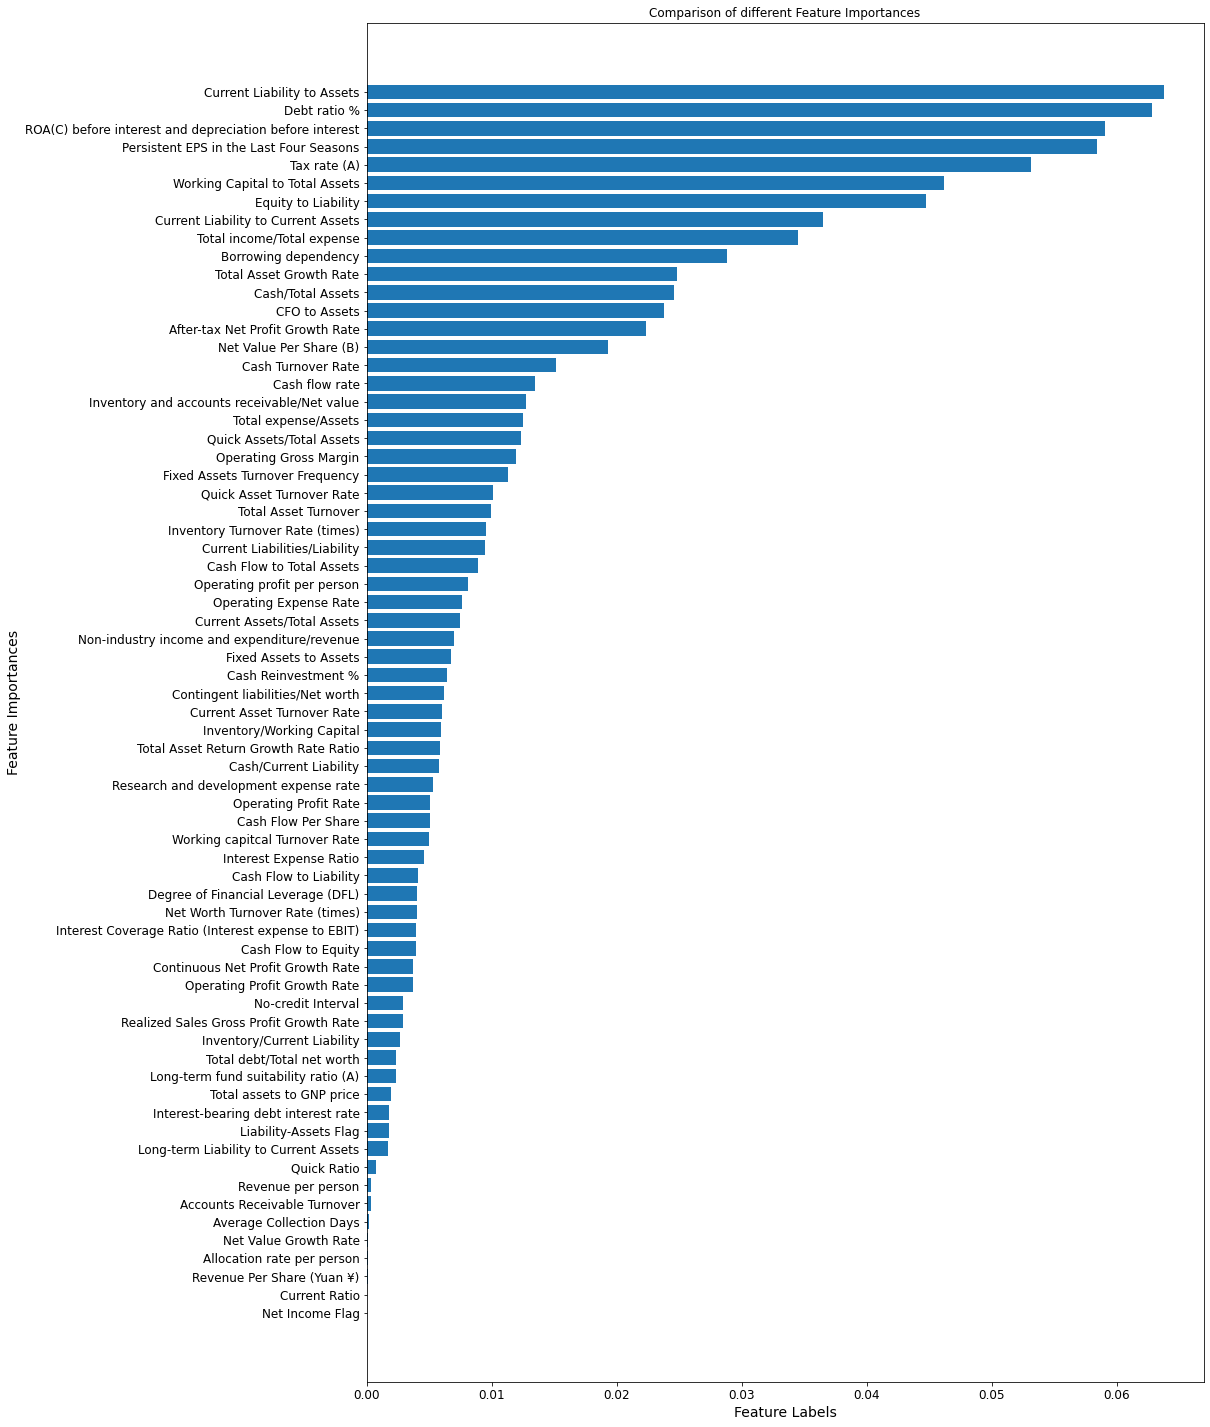

In [24]:
# feature selection (tree-based)

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

clf = ExtraTreesClassifier(n_estimators=50, random_state=45)
clf = clf.fit(X_train_prepared, y_train)
feature_importance = clf.feature_importances_
  
# Normalizing the individual importances 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        clf.estimators_], 
                                        axis = 0) 

tbfs = pd.DataFrame(
    {"X": X_train_prepared.columns, "FI": feature_importance_normalized}
)

tbfs = tbfs.sort_values('FI',ascending=True)


# Plotting a Bar Graph to compare the models 
plt.figure(figsize=(15,25))
plt.barh(y=tbfs['X'],width=tbfs['FI']) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances') 
plt.title('Comparison of different Feature Importances') 
plt.show()


In [37]:
chosen_features = tbfs.nlargest(5,'FI')

#### Selected Features

In [66]:
chosen_features

,X,FI
44,Current Liability to Assets,0.063753
25,Debt ratio %,0.062828
0,ROA(C) before interest and depreciation before...,0.059095
10,Persistent EPS in the Last Four Seasons,0.058455
8,Tax rate (A),0.053120


In [39]:
## Training and test set with selected features
X_train_prepared = X_train_prepared[chosen_features['X']]
X_test_prepared = X_test_prepared[chosen_features['X']]
X_test_final_prepared = X_test_final_prepared[chosen_features['X']]

## MLflow

In [41]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from IPython.display import Image
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier

In [42]:
hyperparameters = {"max_depth":scope.int(hp.quniform("max_depth",2,100,5)),
                "n_estimators":scope.int(hp.quniform("n_estimators",2,100,1)),
                "num_leaves": scope.int(hp.quniform("num_leaves",2,50,1)),
                "reg_alpha": hp.loguniform('reg_li',-5,5),
                "random_state":1,
                "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.5)),
                "min_child_weight": hp.uniform('min_child_weight', 0.5, 10),
                "boosting": hp.choice("boosting",["gbdt","dart","goss"]),
                "objective":"binary"}

In [43]:
def train_model(parameters):
    mlflow.lightgbm.autolog()
    with mlflow.start_run(nested=True):
        booster = lgb.LGBMClassifier()
        booster.set_params(**parameters)
        booster.fit(X_train_prepared,y_train)
        
        mlflow.log_params(parameters)
        
        score = cross_val_score(booster, X_train_prepared, y_train, cv=5, scoring = "f1_macro",n_jobs=-1)
        mean_score = np.mean(score)
        
        mlflow.log_metric('f1_macro', mean_score)
        
        return{'status':STATUS_OK,
               "loss":mean_score,
               'booster':booster.get_params}
    
with mlflow.start_run(run_name='lightgbm_bankruptcy'):
    best_params = fmin(
        fn=train_model,
        space=hyperparameters,
        algo=tpe.suggest,
        max_evals = 50,
        trials = Trials(),
        rstate=np.random.RandomState(1))

[LightGBM] [Warning]                                                                                                   
boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt                                 
  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



  2%|▉                                                | 1/50 [00:03<02:32,  3.11s/trial, best loss: 0.9093834433333114]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



  6%|██▉                                              | 3/50 [00:04<01:02,  1.32s/trial, best loss: 0.8910833280539636]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 10%|████▉                                            | 5/50 [00:05<00:28,  1.60trial/s, best loss: 0.8769371689583345]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 14%|██████▊                                          | 7/50 [00:05<00:15,  2.75trial/s, best loss: 0.8605706110448047]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 16%|███████▊                                         | 8/50 [00:05<00:13,  3.20trial/s, best loss: 0.8605706110448047]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 18%|████████▊                                        | 9/50 [00:06<00:14,  2.76trial/s, best loss: 0.8605706110448047]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 20%|█████████▌                                      | 10/50 [00:06<00:15,  2.65trial/s, best loss: 0.8605706110448047]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 22%|██████████▌                                     | 11/50 [00:07<00:13,  2.84trial/s, best loss: 0.8605706110448047]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 26%|████████████▍                                   | 13/50 [00:07<00:09,  3.70trial/s, best loss: 0.8605706110448047]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 30%|██████████████▍                                 | 15/50 [00:07<00:08,  4.09trial/s, best loss: 0.8605706110448047]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 32%|███████████████▎                                | 16/50 [00:08<00:09,  3.52trial/s, best loss: 0.8605706110448047]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 36%|█████████████████▎                              | 18/50 [00:08<00:08,  3.72trial/s, best loss: 0.8605706110448047]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 38%|██████████████████▏                             | 19/50 [00:09<00:08,  3.71trial/s, best loss: 0.8605706110448047]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 40%|███████████████████▏                            | 20/50 [00:09<00:08,  3.40trial/s, best loss: 0.8605706110448047]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 44%|█████████████████████                           | 22/50 [00:09<00:07,  3.81trial/s, best loss: 0.8368050446102805]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 48%|███████████████████████                         | 24/50 [00:10<00:05,  4.68trial/s, best loss: 0.8368050446102805]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 52%|████████████████████████▉                       | 26/50 [00:10<00:04,  5.29trial/s, best loss: 0.8368050446102805]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 56%|██████████████████████████▉                     | 28/50 [00:11<00:04,  5.04trial/s, best loss: 0.8368050446102805]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 58%|███████████████████████████▊                    | 29/50 [00:11<00:04,  5.02trial/s, best loss: 0.8368050446102805]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


 60%|████████████████████████████▊                   | 30/50 [00:11<00:04,  4.93trial/s, best loss: 0.8368050446102805]

 62%|█████████████████████████████▊                  | 31/50 [00:11<00:03,  4.99trial/s, best loss: 0.8368050446102805]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 64%|██████████████████████████████▋                 | 32/50 [00:11<00:03,  4.98trial/s, best loss: 0.8368050446102805]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 68%|████████████████████████████████▋               | 34/50 [00:12<00:03,  4.22trial/s, best loss: 0.8368050446102805]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 70%|█████████████████████████████████▌              | 35/50 [00:12<00:03,  4.45trial/s, best loss: 0.8368050446102805]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 74%|███████████████████████████████████▌            | 37/50 [00:12<00:02,  4.91trial/s, best loss: 0.8368050446102805]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


 76%|████████████████████████████████████▍           | 38/50 [00:13<00:02,  5.43trial/s, best loss: 0.8368050446102805]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 80%|██████████████████████████████████████▍         | 40/50 [00:13<00:02,  4.97trial/s, best loss: 0.8303804119982668]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 84%|████████████████████████████████████████▎       | 42/50 [00:13<00:01,  5.20trial/s, best loss: 0.8303804119982668]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 88%|██████████████████████████████████████████▏     | 44/50 [00:14<00:01,  4.54trial/s, best loss: 0.8303804119982668]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 90%|███████████████████████████████████████████▏    | 45/50 [00:14<00:01,  3.40trial/s, best loss: 0.8303804119982668]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 94%|█████████████████████████████████████████████   | 47/50 [00:15<00:00,  3.69trial/s, best loss: 0.8303804119982668]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



 98%|███████████████████████████████████████████████ | 49/50 [00:15<00:00,  4.25trial/s, best loss: 0.8303804119982668]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



100%|████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11trial/s, best loss: 0.8303804119982668]


## Real Model

In [44]:
import mlflow
df = mlflow.search_runs(filter_string="metric.f1_macro > 0.8")

In [45]:
df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.f1_macro,params.boosting,params.min_child_weight,params.n_estimators,params.objective,params.reg_alpha,params.max_depth,params.num_leaves,params.random_state,params.learning_rate,tags.mlflow.source.name,tags.mlflow.parentRunId,tags.mlflow.user,tags.mlflow.source.type
0,895eb9c0fc774f228050e33c6f7a247d,0,FINISHED,file:///C:/Users/User/ML%202/mlruns/0/895eb9c0...,2021-04-10 21:23:46.484000+00:00,2021-04-10 21:23:46.673000+00:00,0.901950,goss,4.6359803749989705,23,binary,9.477135148702553,85,35,1,0.06769968586664343,C:\ProgramData\Anaconda3\lib\site-packages\ipy...,f92d301c5e794280977516159360bc55,User,LOCAL
1,35a4fc3844cb40dabf98e7e39dd152f1,0,FINISHED,file:///C:/Users/User/ML%202/mlruns/0/35a4fc38...,2021-04-10 21:23:46.319000+00:00,2021-04-10 21:23:46.455000+00:00,0.898740,gbdt,5.34229367247244,7,binary,3.1947601038782194,70,27,1,0.030984142754335423,C:\ProgramData\Anaconda3\lib\site-packages\ipy...,f92d301c5e794280977516159360bc55,User,LOCAL
2,8b0ddc98dba444d2a24918bb8ce115b6,0,FINISHED,file:///C:/Users/User/ML%202/mlruns/0/8b0ddc98...,2021-04-10 21:23:46.075000+00:00,2021-04-10 21:23:46.292000+00:00,0.881207,dart,2.711221316861649,58,binary,41.90555082217048,60,33,1,0.38427605778581847,C:\ProgramData\Anaconda3\lib\site-packages\ipy...,f92d301c5e794280977516159360bc55,User,LOCAL
3,1976fd25de5e4155a70986dd0b900d16,0,FINISHED,file:///C:/Users/User/ML%202/mlruns/0/1976fd25...,2021-04-10 21:23:45.875000+00:00,2021-04-10 21:23:46.036000+00:00,0.885814,goss,7.263312141179093,2,binary,0.6374113607365204,5,19,1,0.17801621789456254,C:\ProgramData\Anaconda3\lib\site-packages\ipy...,f92d301c5e794280977516159360bc55,User,LOCAL
4,b61130104ed44ccfa192431c2cee252b,0,FINISHED,file:///C:/Users/User/ML%202/mlruns/0/b6113010...,2021-04-10 21:23:45.545000+00:00,2021-04-10 21:23:45.843000+00:00,0.891248,goss,5.509630197797747,79,binary,19.8587763458275,20,24,1,0.02312799336834514,C:\ProgramData\Anaconda3\lib\site-packages\ipy...,f92d301c5e794280977516159360bc55,User,LOCAL
5,935af0e9e913437db3cd94f6bc35b6ea,0,FINISHED,file:///C:/Users/User/ML%202/mlruns/0/935af0e9...,2021-04-10 21:23:45.079000+00:00,2021-04-10 21:23:45.515000+00:00,0.901451,dart,6.785848737686534,99,binary,3.6978069777153424,80,21,1,0.04183310927681669,C:\ProgramData\Anaconda3\lib\site-packages\ipy...,f92d301c5e794280977516159360bc55,User,LOCAL
6,1758779a85cf4d6a8d5a272ade55b1d2,0,FINISHED,file:///C:/Users/User/ML%202/mlruns/0/1758779a...,2021-04-10 21:23:44.877000+00:00,2021-04-10 21:23:45.048000+00:00,0.897119,goss,6.211949735903085,13,binary,0.19426778830121363,95,27,1,0.03206648308193621,C:\ProgramData\Anaconda3\lib\site-packages\ipy...,f92d301c5e794280977516159360bc55,User,LOCAL
7,434ef90a767e4e569ae3922cafb122e3,0,FINISHED,file:///C:/Users/User/ML%202/mlruns/0/434ef90a...,2021-04-10 21:23:44.569000+00:00,2021-04-10 21:23:44.845000+00:00,0.857502,dart,7.120151403375866,68,binary,82.4566758284404,40,22,1,0.01012490957926247,C:\ProgramData\Anaconda3\lib\site-packages\ipy...,f92d301c5e794280977516159360bc55,User,LOCAL
8,e0b2f541160742f0982c748d1b11c0d1,0,FINISHED,file:///C:/Users/User/ML%202/mlruns/0/e0b2f541...,2021-04-10 21:23:44.400000+00:00,2021-04-10 21:23:44.535000+00:00,0.899978,goss,3.7087506608180387,13,binary,0.03556953358985318,70,32,1,0.021286830111750053,C:\ProgramData\Anaconda3\lib\site-packages\ipy...,f92d301c5e794280977516159360bc55,User,LOCAL
9,ad30a2e2edbf4f8a8505a2b35c691b30,0,FINISHED,file:///C:/Users/User/ML%202/mlruns/0/ad30a2e2...,2021-04-10 21:23:44.197000+00:00,2021-04-10 21:23:44.373000+00:00,0.883526,goss,3.4045137481345735,24,binary,28.154456847882194,60,29,1,0.05727176890852972,C:\ProgramData\Anaconda3\lib\site-packages\ipy...,f92d301c5e794280977516159360bc55,User,LOCAL


In [46]:
df.sort_values(by='metrics.f1_macro').iloc[0]

run_id                                      a05c1e1b95fb446abaff468f35bc9494
experiment_id                                                              0
status                                                              FINISHED
artifact_uri               file:///C:/Users/User/ML%202/mlruns/0/a05c1e1b...
start_time                                  2021-04-10 21:23:44.038000+00:00
end_time                                    2021-04-10 21:23:44.156000+00:00
metrics.f1_macro                                                     0.83038
params.boosting                                                         goss
params.min_child_weight                                    7.214981846279901
params.n_estimators                                                       12
params.objective                                                      binary
params.reg_alpha                                          146.82844991781127
params.max_depth                                                          90

In [49]:
params = df.sort_values(by='metrics.f1_macro').iloc[0,7:16].to_dict()

In [50]:
import lightgbm

In [51]:
train_data = lightgbm.Dataset(X_train_prepared, label=y_train)
valid_data = lightgbm.Dataset(X_test_prepared, label=y_test)
test_data = lightgbm.Dataset(X_test_final_prepared, label=y_test_final)

In [52]:
X_train_prepared.shape

(7926, 5)

In [70]:
type(X_test_final_prepared.iloc[0,0])

numpy.float64

In [53]:
parameters = {
    'objective': params["params.objective"],
    'boosting': params["params.boosting"],
    'num_leaves': int(params["params.num_leaves"]),
    'learning_rate': float(params["params.learning_rate"]),
    'n_estimators': int(params["params.n_estimators"]),
    'min_child_weight': float(params["params.min_child_weight"]),
    'random_state': 1,
    'reg_alpha':float(params["params.reg_alpha"]),
    'max_depth': int(params["params.max_depth"])
}

In [54]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=valid_data)

2021/04/10 17:25:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '73831f7aa1e44c2ab2ef91a0dc554c8a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3963, number of negative: 3963
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 7926, number of used features: 5
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.682829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.672977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.663566
[LightGBM] [Warning] No further

In [55]:
y_pred = model.predict(X_test_final_prepared)
y_pred=y_pred.round(0)
y_pred=y_pred.astype(int)

In [56]:
from sklearn.metrics import f1_score
f1_score(y_test_final, y_pred, average='weighted')

0.910540038785356

In [77]:
t = X_test[chosen_features['X']]

In [78]:
t.shape

(1364, 5)

In [81]:
t.reset_index(inplace=True)

In [84]:
t.drop(columns='index',inplace=True)

In [108]:
temp = model.predict(t.iloc[0:3,:])

In [109]:
temp

array([0.40355086, 0.40355086, 0.40355086])

## Pickling the model

In [58]:
import pickle as pkl
pkl.dump(model, open('model.pkl','wb'))

In [ ]:
# 'weighted':
# Calculate metrics for each label, and find their average weighted by support 
#(the number of true instances for each label). This alters ‘macro’ to account 
#for label imbalance; it can result in an F-score that is not between precision and recall.